In [11]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib
/Users/dkawata/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



# M2M with one-dimensional self-gravity for a perturbed disk

Here we investigate M2M with one-dimensional self-gravity (and optionally a constant density background) using a target 1D disk which is perturbed.

## Mock observations

First we generate some mock observations for a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk). Then, we will let it evolve for a while to let it fully equilibrate, and then inject energy into it in non-adiabatic manner. First we setup the disk and evolve it:

In [60]:
n_init = 100000
sigma_true = 0.5
totmass_true = 1.0
zh_true = sigma_true**2./totmass_true
tdyn = zh_true/sigma_true
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn =', zh_true, tdyn)

zh, tdyn = 0.25 0.5


In [61]:
g = wendy.nbody(z_init, vz_init, m_init, 0.05*tdyn, approx=True, nleap=1)

In [62]:
nt = 3000
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
Et = numpy.empty((nt+1))
zt[:, 0] = z_init
vzt[:, 0] = vz_init
Et[0] = wendy.energy(z_init, vz_init, m_init)
for ii in tqdm.trange(nt):
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    Et[ii+1] = wendy.energy(tz, tvz, m_init)
z_start= zt[:, -1]
vz_start= vzt[:, -1]

100%|██████████| 3000/3000 [02:17<00:00, 21.86it/s]


Movie to check the stability. 

In [63]:
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -2.0
zmax = 2.0
rhomin = 10.**-3.
rhomax = 1.2
nbinz = 101
a = ax.hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt[:, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Now we inject a perturbation into about 5 % of the orbits in a non-adiabatic manner, by doing it in brief episodes rather than over multiple dynamical times:

In [64]:
nt = 3000
z = copy.deepcopy(z_start)
vz = copy.deepcopy(vz_start)
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
zt[:,0] = z
vzt[:,0] = vz
launch_v = 2.0*sigma_true
frac_lost = 0.1
time_lost = 10
nlost = int(round(frac_lost*n_init/1./time_lost))
g= wendy.nbody(z, vz, m_init, 0.05*tdyn, approx=True, nleap=1)
for ii in tqdm.trange(nt):
    if (ii >= 300 and ii < 300+time_lost): 
        # or (ii >= 400 and ii < 400+time_lost) \
        # or (ii >= 500 and ii < 500+time_lost) \
        # or (ii >= 600 and ii < 600+time_lost):
        idx= numpy.random.permutation(n_init)[:nlost] 
        #numpy.argpartition(numpy.fabs(x),nlost)[:nlost]
        if numpy.random.uniform() < 0.5:
            vz[idx[:nlost//2]]= launch_v
            vz[idx[nlost//2:]]= -launch_v
        else:
            vz[idx[:nlost//2]]= -launch_v
            vz[idx[nlost//2:]]= launch_v
        g= wendy.nbody(z, vz, m_init, 0.05*tdyn, approx=True, nleap=1)
    z, vz = next(g)
    if (ii >= 300 and ii < 300+time_lost):
        # or (ii >= 400 and ii < 400+time_lost) \
        # or (ii >= 500 and ii < 500+time_lost) \
        # or (ii >= 600 and ii < 600+time_lost):
        zt[:, ii+1]= z
        vzt[:, ii+1]= vz
        vzt[idx, ii+1]= numpy.nan
    else:
        zt[:, ii+1]= z
        vzt[:, ii+1]= vz

100%|██████████| 3000/3000 [01:43<00:00, 29.02it/s]


In [50]:
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -2.0
zmax = 2.0
rhomin = 10.**-3.
rhomax = 1.2
nbinz = 101
a = ax.hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    if ii*subsamp < 300:
        norm = 1./n_init
    elif ii*subsamp < 300+time_lost:
        norm = 1./(n_init-(ii*subsamp-300.)*nlost)
    # elif ii*subsamp < 400.:
    #    norm = 1./(n_init-time_lost*nlost)
    # elif ii*subsamp < 400+time_lost:
    #    norm = 1./(n_init-2.*time_lost*nlost-(ii*subsamp-400.)*nlost)
    # elif ii*subsamp < 500.:
    #    norm = 1./(n_init-2.*time_lost*nlost)
    # elif ii*subsamp < 500+time_lost:
    #    norm = 1./(n_init-2.*time_lost*nlost-(ii*subsamp-500.)*nlost)
    # elif ii*subsamp < 600:
    #    norm = 1./(n_init-3.*time_lost*nlost)
    # elif ii*subsamp < 600+time_lost:
    #    norm = 1./(n_init-3.*time_lost*nlost-(ii*subsamp-600.)*nlost)
    else:
        norm= 1./(n_init-time_lost*nlost)
    idx = numpy.any(numpy.isnan(vzt[:,:ii*subsamp]), axis=1)
    idx = numpy.logical_not(idx)
    a = ax.hist(zt[idx, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=nbinz/(zmax-zmin)*norm*numpy.ones(n_init)[idx])
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

The density now clearly evolves non-adiabatically and has large fluctuations (energy is injected around  t=15), but in the end the density settles back down to the original exponential distribution.

We will set up the target using at step=1000.

In [158]:
# selected step
istep = 1000
idz = numpy.any(numpy.isnan(vzt[:, :istep]), axis=1)
idz = numpy.logical_not(idz)
n_mock = numpy.size(zt[idz, istep])
print('Old and New n_mock =',numpy.size(zt[:, istep]), n_mock)
z_mock = zt[idz, istep]
vz_mock = vzt[idz, istep]
m_mock = m_init[idz]
totmass_true = numpy.sum(m_mock)
print('New totmass =', totmass_true) 

Old and New n_mock = 100000 90457
New totmass = 0.90457


The density looks like a $\mathrm{sech}^2$ disk (cored near the center, exponential at large distances) with some fluctuations:

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



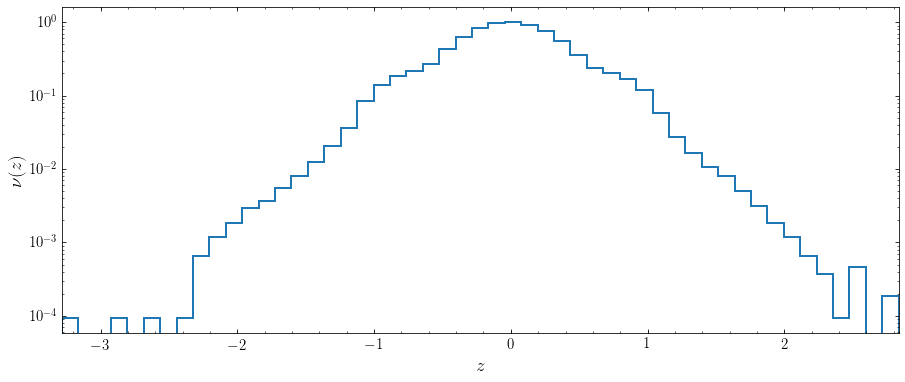

In [159]:
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [192]:
zsun_true= 0.05
# We only observe the density at a few z
z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0,
                    0. -0.2, -0.4, -0.6, -0.8, -1.0, -1.2,
                    -1.4, -1.6, -1.8, -2.0])
# z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 
#                     0. -0.2, -0.4, -0.6, -0.8, -1.0])
h_obs= 0.1
dens_obs= hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<ErrorbarContainer object of 3 artists>

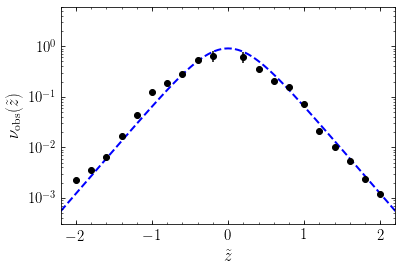

In [194]:
zmin = -2.2
zmax = 2.2
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[0.0003,6.])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [195]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

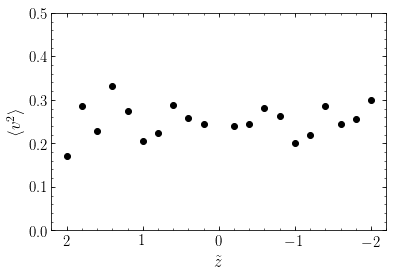

In [196]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[0.0,0.5],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [197]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]

## M2M fit

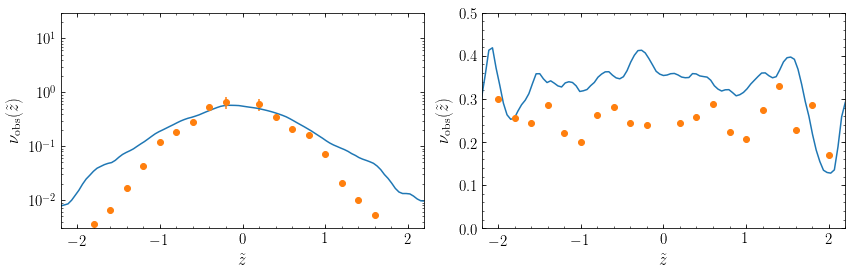

In [211]:
n_m2m= 4000
sigma_init= 0.6
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.0,0.5])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

Run without any smoothing:

In [212]:
step= numpy.pi/3.*10.**-2.
nstep= 1000
# eps= 10.**-3.5
eps = 10.0**-6.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.2
omega_m2m= 0.
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10)
w_out= w_out[:,0]

 total mass = 0.7090662040192843
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

Velocity dispersions: mock, fit 0.497152117321223 0.4752109205323822
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid lim

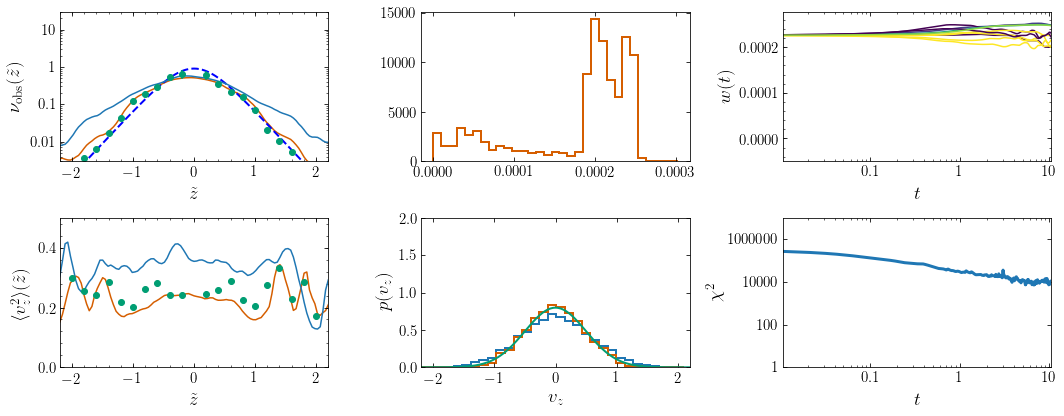

In [213]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,0.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,2.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

with smoothing

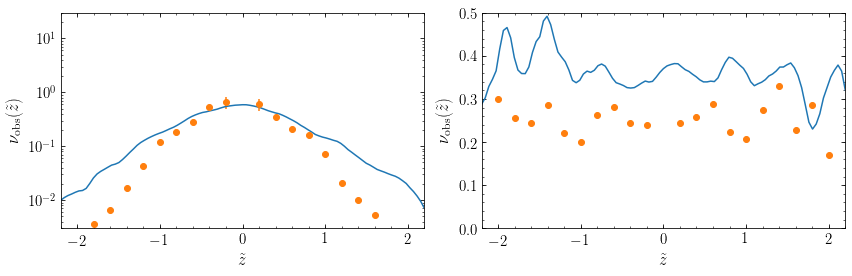

In [214]:
n_m2m= 4000
sigma_init= 0.6
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.0,0.5])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

In [216]:
step= numpy.pi/3.*10.**-2.
nstep= 1000
eps= 10.**-6
smooth= 1./step/100.
st96smooth= True
mu= 10.
h_m2m= 0.2
omega_m2m= 0.
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10)
w_out= w_out[:,0]

/Users/dkawata/work/oned-m2m/WendyM2M/py/hom2m.py:191: RuntimeWarning: invalid value encountered in double_scalars
  deltav2_m2m_new[jj]= (wv2_m2m[jj]/dens_m2m[jj]-v2_obs[jj]) \

/Users/dkawata/work/oned-m2m/WendyM2M/py/hom2m.py:194: RuntimeWarning: divide by zero encountered in true_divide
  return (-(numpy.nansum(numpy.tile(deltav2_m2m/(dens_m2m*v2_obs_noise),

/Users/dkawata/work/oned-m2m/WendyM2M/py/hom2m.py:195: RuntimeWarning: invalid value encountered in multiply
  (len(z_m2m),1)).T*(Wij),axis=0)

/Users/dkawata/work/oned-m2m/WendyM2M/py/hom2m.py:197: RuntimeWarning: invalid value encountered in true_divide
  deltav2_m2m*wv2_m2m/((dens_m2m**2)*v2_obs_noise),



In [217]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,0.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,2.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

 total mass = 17870957351.293373
/Users/dkawata/work/oned-m2m/WendyM2M/py/hom2m.py:58: RuntimeWarning: invalid value encountered in double_scalars
  /numpy.nansum(w*kernel(numpy.fabs(zo-z+zsun),h_obs))

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

Velocity dispersions: mock, fit 0.497152117321223 216664655.61118

OverflowError: cannot convert float infinity to integer

/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log10

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x180b365b70> (for post_execute):


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 1080x432 with 6 Axes>